In [1]:
import numpy as np
import uproot4 as uproot
import math
import matplotlib.pyplot as plt
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
import os
from sklearn.model_selection import StratifiedKFold

In [2]:
tree = uproot.open( "/gpfs/loomis/home.grace/ys668/output/seed_1C0B_mltree.root:Stg" )

In [3]:
xyzxyzt = tree.arrays( [ "Crit2_RZRatio_x1", "Crit2_RZRatio_y1", "Crit2_RZRatio_z1", "Crit2_RZRatio_x2", "Crit2_RZRatio_y2", "Crit2_RZRatio_z2", "Crit2_RZRatio_trackIds" ], library='np'  )

In [4]:
x1 = xyzxyzt['Crit2_RZRatio_x1']
y1 = xyzxyzt['Crit2_RZRatio_y1']
z1 = xyzxyzt['Crit2_RZRatio_z1']
x2 = xyzxyzt['Crit2_RZRatio_x2']
y2 = xyzxyzt['Crit2_RZRatio_y2']
z2 = xyzxyzt['Crit2_RZRatio_z2']
tid = xyzxyzt['Crit2_RZRatio_trackIds']

## Train with (x,y,z,x,y,z)

In [5]:
%%time

X = [[], [], [], [], [], []]
Y = []

# build up 1d arrays for training
for iEvent in np.arange( 0, len(x1) ) :
    for i in np.arange( 0, len(x1[iEvent]) ) :
        X[0].append( x1[iEvent][i] )
        X[1].append( y1[iEvent][i] )
        X[2].append( z1[iEvent][i] )
        
        X[3].append( x2[iEvent][i] )
        X[4].append( y2[iEvent][i] )
        X[5].append( z2[iEvent][i] )
        
        if tid[iEvent][i] > 0 :
            Y.append( 1 )
        else :
            Y.append( 0 )

CPU times: user 1min 44s, sys: 2.08 s, total: 1min 46s
Wall time: 1min 47s


In [6]:
X = np.transpose( np.array( X ))
y = np.array( Y )

In [7]:
print( "X =", X.shape )
print( "y =", y.shape )

X = (12877245, 6)
y = (12877245,)


In [8]:
def build_model() :
    model = Sequential()
    model.add(Dense(20, input_dim=6, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1))
    model.summary()
    return model

In [9]:
skf = StratifiedKFold(n_splits=2)
skf.get_n_splits(X, y)

2

In [10]:
print(skf)

StratifiedKFold(n_splits=2, random_state=None, shuffle=False)


In [11]:
for train_index, test_index in skf.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [ 6434959  6434960  6434961 ... 12877242 12877243 12877244] TEST: [      0       1       2 ... 6512172 6512210 6512248]
TRAIN: [      0       1       2 ... 6512172 6512210 6512248] TEST: [ 6434959  6434960  6434961 ... 12877242 12877243 12877244]


In [12]:
print( "X_train =", X_train.shape )
print( "y_train =", y_train.shape )
print( "X_test =", X_test.shape )
print( "y_test =", y_test.shape )

X_train = (6438623, 6)
y_train = (6438623,)
X_test = (6438622, 6)
y_test = (6438622,)


In [13]:
# Get the model built in the function above
model = build_model()
# compile the model and set the loss function, optimizer and metrics to check during training.
model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                140       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________


In [14]:
%%time
history = model.fit(X_train, y_train, epochs=10, batch_size=10,  verbose=1)

Epoch 1/10
643863/643863 [==============================] - 755s 1ms/step - loss: 0.0360 - mse: 0.0360 - mae: 0.1032
Epoch 2/10
643863/643863 [==============================] - 650s 1ms/step - loss: 0.0321 - mse: 0.0321 - mae: 0.0958
Epoch 3/10
643863/643863 [==============================] - 552s 858us/step - loss: 0.0322 - mse: 0.0322 - mae: 0.0957
Epoch 4/10
643863/643863 [==============================] - 552s 857us/step - loss: 0.0322 - mse: 0.0322 - mae: 0.0957
Epoch 5/10
643863/643863 [==============================] - 552s 858us/step - loss: 0.0322 - mse: 0.0322 - mae: 0.0956
Epoch 6/10
643863/643863 [==============================] - 552s 857us/step - loss: 0.0322 - mse: 0.0322 - mae: 0.0957
Epoch 7/10
643863/643863 [==============================] - 551s 856us/step - loss: 0.0322 - mse: 0.0322 - mae: 0.0956
Epoch 8/10
643863/643863 [==============================] - 549s 852us/step - loss: 0.0322 - mse: 0.0322 - mae: 0.0957s - loss: 0.0322 - mse: 0.0322 - mae: 0.
Epoch 9/10
6

In [15]:
model.save_weights('./models/10epochs')

In [16]:
y_pred = np.array(model.predict(X_test))

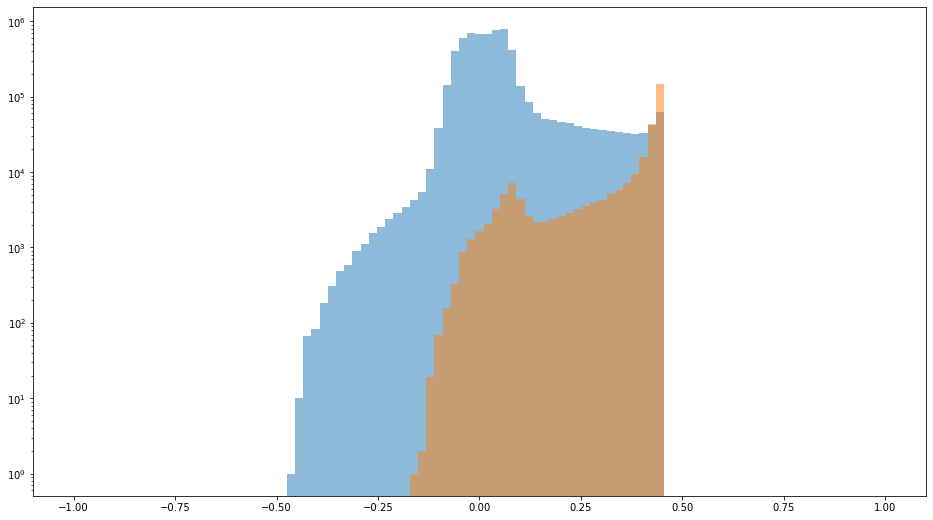

In [19]:
plt.figure(figsize=(16,9))
plt.hist( [ y0[0] for y0, y1 in zip(y_pred, y_test) if y1 == 0 ], bins=np.linspace( -1.0, 1.0, 100 ), alpha=0.5 )
plt.hist( [ y0[0] for y0, y1 in zip(y_pred, y_test) if y1 == 1 ], bins=np.linspace( -1.0, 1.0, 100 ), alpha=0.5 )
plt.semilogy()
plt.show()

In [43]:
import tensorflow.python.keras as k

In [45]:
dir(k.losses)

['BCE',
 'BinaryCrossentropy',
 'CategoricalCrossentropy',
 'CategoricalHinge',
 'CosineSimilarity',
 'Hinge',
 'Huber',
 'K',
 'KLD',
 'KLDivergence',
 'LABEL_DTYPES_FOR_LOSSES',
 'LogCosh',
 'Loss',
 'LossFunctionWrapper',
 'MAE',
 'MAPE',
 'MSE',
 'MSLE',
 'MeanAbsoluteError',
 'MeanAbsolutePercentageError',
 'MeanSquaredError',
 'MeanSquaredLogarithmicError',
 'Poisson',
 'SparseCategoricalCrossentropy',
 'SquaredHinge',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_maybe_convert_labels',
 'abc',
 'absolute_import',
 'ag_ctx',
 'array_ops',
 'autograph',
 'bce',
 'binary_crossentropy',
 'categorical_crossentropy',
 'categorical_hinge',
 'context',
 'cosine_similarity',
 'deserialize',
 'deserialize_keras_object',
 'dispatch',
 'distribution_strategy_context',
 'division',
 'doc_controls',
 'get',
 'hinge',
 'huber',
 'huber_loss',
 'is_categorical_crossentropy',
 'keras_export',
 'kl_divergence',
 'kld',
 'kullb

In [59]:
import math